<a href="https://colab.research.google.com/github/suinkangme/comp433_project/blob/main/COMP433_Project_DK_version2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Developing a robust CNN model to address the challenge of learning with label noise in  CIFAR10 dataset

- CIFAR10 Label : ‘airplane’, ‘automobile’, ‘bird’, ‘cat’, ‘deer’, ‘dog’, ‘frog’, ‘horse’, ‘ship’, ‘truck’.

- image size : 3x32x32




In [ ]:
import torch
import torchvision
import torchvision.transforms as transforms
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import numpy as np
from torch.utils.data import DataLoader, random_split
import os
import matplotlib.pyplot as plt
from IPython.display import clear_output
from torch.optim.lr_scheduler import CosineAnnealingLR

In [ ]:
# Training on GPU
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

## Load and normalize CIFAR10

In [ ]:
# Define the mean and standard deviation of CIFAR-10 dataset
# cifar10_mean = (0.4914, 0.4822, 0.4465)
# cifar10_std = (0.2023, 0.1994, 0.2010)

# imagenet..
imagenet_mean = (0.485, 0.456, 0.406)
imagenet_std = (0.229, 0.224, 0.225)


# Training transformations
transform_train = transforms.Compose([
    transforms.RandomHorizontalFlip(),
    transforms.RandomCrop(32, padding=4),
    transforms.ToTensor(),
    transforms.Normalize(mean=imagenet_mean, std=imagenet_std)
])

# Validation and testing transformations
transform_val = transforms.Compose([
    transforms.ToTensor(),
    transforms.RandomCrop(32, padding=4),
    transforms.Normalize(mean=imagenet_mean, std=imagenet_std)
])

transform_test = transforms.Compose([
    transforms.ToTensor(),
    transforms.RandomCrop(32, padding=4),
    transforms.Normalize(mean=imagenet_mean, std=imagenet_std)
])

In [ ]:
# download dataset for training
cifar_dataset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=None)

# 데이터를 train과 validation으로 나누기 위해 인덱스 생성
dataset_size = len(cifar_dataset)
validation_split = 0.2
val_size = int(validation_split * dataset_size)
train_size = dataset_size - val_size

# 데이터를 나누기
train_dataset, val_dataset = random_split(cifar_dataset, [train_size, val_size])

# 적절한 transform 적용
train_dataset.dataset.transform = transform_train
val_dataset.dataset.transform = transform_val

# 데이터 로더 설정
batch_size = 512
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)


Files already downloaded and verified


In [ ]:
class_names = cifar_dataset.classes
print(class_names)

['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']


In [ ]:
train_dataset[0][0].shape

torch.Size([3, 32, 32])

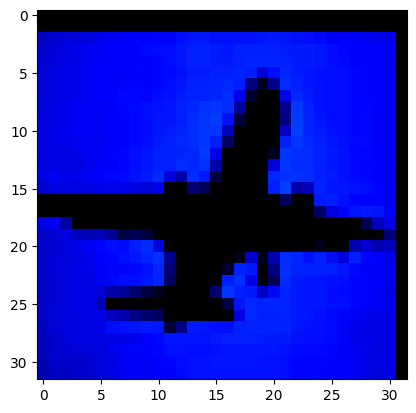

In [ ]:
plt.imshow(train_dataset[4][0].permute(1, 2, 0).numpy())

In [ ]:

# test dataset
test_dataset = torchvision.datasets.CIFAR10(root='./data',
                                          train=False,
                                          download=True,
                                          transform = transform_test)

test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

Files already downloaded and verified


## Define & train with a  baseline CNN model

In [ ]:
class BaselineModel(nn.Module):
  def __init__(self):
    super(BaselineModel,self).__init__()
    self.features = nn.Sequential(
      nn.Conv2d(3, 8, kernel_size=3, padding = 1),  # (input channel, output channels, kernel size, padding)  32*32*8
      nn.ReLU(inplace=True), # activation function modifies the input tensor directly
      nn.Conv2d(8, 16, kernel_size=3, padding=1),
      nn.ReLU(inplace=True),
      nn.MaxPool2d(kernel_size=2,stride=2), # 16*16*16

      nn.Conv2d(16, 32, kernel_size=3, padding=1),
      nn.ReLU(inplace=True),
      nn.Conv2d(32, 64, kernel_size=3, padding=1),
      nn.ReLU(inplace=True),
      nn.Conv2d(64, 128, kernel_size=3, padding=1),
      nn.MaxPool2d(kernel_size=2,stride=2) # 8*8*128
    )

    # # fully connected layers
    # self.fc_layers = nn.Sequential(
    #   nn.Linear(128*8*8, 120),
    #   nn.ReLU(inplace=True),
    #   nn.Linear(120,84),
    #   nn.ReLU(inplace=True),
    #   nn.Linear(84,10)
    # )

    # fully connected layers
    self.fc_layers = nn.Sequential(
      nn.Linear(128*8*8, 512),
      nn.ReLU(inplace=True),
      nn.Linear(512,10)
    )


    # Apply Xavier initialization to the weights of linear layers
    for m in self.fc_layers:
        if isinstance(m, nn.Linear):
            nn.init.xavier_uniform_(m.weight)


  def forward(self, x):
    x = self.features(x)
    x = torch.flatten(x,1)
    x = self.fc_layers(x)
    return x



In [ ]:
base_model = BaselineModel().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(base_model.parameters(), lr=0.01, momentum=0.9, weight_decay=1e-4)
scheduler = CosineAnnealingLR(optimizer, T_max=120) # Learning rate scheduler (cosine annealing)


In [ ]:
num_epochs = 10

for epoch in range(num_epochs):
    # Training
    base_model.train()
    total_train_loss = 0.0
    correct_train = 0
    total_train = 0

    for inputs, labels in train_loader:
        # Move data to GPU
        inputs, labels = inputs.to(device), labels.to(device)

        # Zero the gradients
        optimizer.zero_grad()

        # Forward pass
        outputs = base_model(inputs)
        loss = criterion(outputs, labels)

        # Backward pass and optimization
        loss.backward()
        optimizer.step()

        total_train_loss += loss.item()
        _, predicted = torch.max(outputs.data, 1)
        total_train += labels.size(0)
        correct_train += (predicted == labels).sum().item()

    average_train_loss = total_train_loss / len(train_loader)
    train_acc = 100 * correct_train / total_train


    # Update learning rate
    scheduler.step()


    # Validation
    base_model.eval()
    total_val_loss = 0.0
    correct_val = 0
    total_val = 0

    with torch.no_grad():
        for inputs, labels in val_loader:
            # Move data to GPU
            inputs, labels = inputs.to(device), labels.to(device)

            # Forward pass
            outputs = base_model(inputs)
            loss = criterion(outputs, labels)

            total_val_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            total_val += labels.size(0)
            correct_val += (predicted == labels).sum().item()

    average_val_loss = total_val_loss / len(val_loader)
    val_acc = 100 * correct_val / total_val

    print(f'Epoch {epoch + 1}/{num_epochs}, '
          f'Train Loss: {average_train_loss:.4f}, Train Accuracy: {train_acc:.2f}%, '
          f'Validation Loss: {average_val_loss:.4f}, Validation Accuracy: {val_acc:.2f}')


Epoch 1/10, Train Loss: 2.1701, Train Accuracy: 20.16%, Validation Loss: 2.0223, Validation Accuracy: 24.61
Epoch 2/10, Train Loss: 1.8545, Train Accuracy: 32.88%, Validation Loss: 1.7341, Validation Accuracy: 36.91
Epoch 3/10, Train Loss: 1.6457, Train Accuracy: 40.88%, Validation Loss: 1.5873, Validation Accuracy: 42.76
Epoch 4/10, Train Loss: 1.5351, Train Accuracy: 44.83%, Validation Loss: 1.5002, Validation Accuracy: 45.68
Epoch 5/10, Train Loss: 1.4446, Train Accuracy: 48.20%, Validation Loss: 1.4670, Validation Accuracy: 46.99
Epoch 6/10, Train Loss: 1.3562, Train Accuracy: 50.92%, Validation Loss: 1.3940, Validation Accuracy: 50.29
Epoch 7/10, Train Loss: 1.2889, Train Accuracy: 54.19%, Validation Loss: 1.2715, Validation Accuracy: 54.84
Epoch 8/10, Train Loss: 1.2240, Train Accuracy: 56.38%, Validation Loss: 1.4044, Validation Accuracy: 50.43
Epoch 9/10, Train Loss: 1.1780, Train Accuracy: 58.14%, Validation Loss: 1.1567, Validation Accuracy: 58.98
Epoch 10/10, Train Loss: 1.1

In [ ]:
# testing
base_model.eval()

# Variables to store predictions and ground truth labels
num_correct_predictions = 0
total_num_predictions = 0
test_loss = 0.0

# Iterate over the test dataset
with torch.no_grad():  # temporarily set all requires_grad flags to False
    for inputs, labels in test_loader:
        # Move data to GPU
        inputs, labels = inputs.to(device), labels.to(device)

        # Forward pass
        outputs = base_model(inputs)
        loss = criterion(outputs, labels)

        # Compute loss and number of accurate predictions
        test_loss += loss.item()
        preds = outputs.argmax(dim=1)
        num_correct_predictions += (preds == labels).sum().item()
        total_num_predictions += labels.size(0)

# Compute average test loss
average_test_loss = test_loss / len(test_loader.dataset)

# Compute accuracy percentage
accuracy = (num_correct_predictions / total_num_predictions) * 100

print(f"Test Accuracy: {accuracy:.2f}%, Average Test Loss: {average_test_loss:.4f}")


Test Accuracy: 58.23%, Average Test Loss: 0.0023


## Noise Labeling
- 5 different noise levels (10%,
30%, 50%, 80%, 90%)

In [ ]:
def apply_label_noise(labels, epsilon, noise_type):
    num_labels = len(labels)
    num_flips = int(epsilon * num_labels)

    if noise_type == 'symmetric':
        # Symmetric label noise
        flip_indices = np.random.choice(num_labels, num_flips, replace=False)
        labels[flip_indices] = np.random.randint(0, 10, num_flips)
    elif noise_type == 'asymmetric':
        # Asymmetric label noise
        flip_rules = {
            9: 1,   # Truck to Automobile
            2: 0,   # Bird to Airplane
            4: 7,   # Deer to Horse
            3: 5,   # Cat to Dog
            5: 3,   # Dog to Cat
        }

        for i in range(num_labels):
            if np.random.random() < epsilon:
                labels[i] = flip_rules.get(labels[i], labels[i])

    return labels

### Symmetric label noise

In [ ]:
# def replace_symmetric_noise(labels, epsilon):
#     num_labels = len(labels)
#     num_flips = int(epsilon * num_labels)

#     # choose the label to be flipped
#     flip_indices = np.random.choice(num_labels, num_flips, replace=True)

#     # filp the label
#     labels[flip_indices] = np.random.randint(0, 10, num_flips)

#     return labels

### Asymmetric label noise

In [ ]:
# def flip_labels_asymmetrically(labels, epsilon):
#     flip_rules = {
#         9: 1,   # Truck to Automobile
#         2: 0,   # Bird to Airplane
#         4: 7,   # Deer to Horse
#         3: 5,   # Cat to Dog
#         5: 3,   # Dog to Cat
#     }

#     flipped_labels = []
#     for label in labels:
#         # Check if label flipping should occur based on epsilon
#         if np.random.random() < epsilon:
#             # Flip the label based on the flip_rules dictionary
#             flipped_label = flip_rules.get(label, label)
#             flipped_labels.append(flipped_label)
#         else:
#             # If no flipping, keep the original label
#             flipped_labels.append(label)

#     return np.array(flipped_labels)


## Train the model with the noise labeling

### Train with the symmetric noise labeling

In [ ]:



# noise_levels
noise_levels = [0.0, 0.2, 0.4, 0.6, 0.8]

# Create a dictionary with keys in the format 'noise_level_{100 * value}'
symmetric_model_dict = {f'noise_level_{int(100 * level)}_sy': None for level in noise_levels}

for epsilon in noise_levels:

    # Define different model for each nose level
    net = BaselineModel().to(device)
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.SGD(net.parameters(), lr=0.01, momentum=0.9, weight_decay=1e-4)
    scheduler = CosineAnnealingLR(optimizer, T_max=120) # Learning rate scheduler (cosine annealing)


    num_epochs = 7


    # net.train()


    print(f"Symmetric Training with noise level: {epsilon}")

    for epoch in range(num_epochs):
        # Training
        net.train()
        total_train_loss = 0.0
        correct_train = 0
        total_train = 0

        for inputs, labels in train_loader:


            labels_noisy = torch.from_numpy(apply_label_noise(labels.numpy(), epsilon=epsilon, noise_type='symmetric'))

            # labels_noisy = torch.from_numpy(replace_symmetric_noise(labels.numpy(), epsilon))

            # Move data to GPU
            inputs, labels_noisy = inputs.to(device), labels_noisy.to(device)

            # Zero the gradients
            optimizer.zero_grad()

            # Forward pass
            outputs = net(inputs)
            loss = criterion(outputs, labels_noisy)

            # Backward pass and optimization
            loss.backward()
            optimizer.step()

            total_train_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            total_train += labels_noisy.size(0)
            correct_train += (predicted == labels_noisy).sum().item()

        average_train_loss = total_train_loss / len(train_loader)
        train_acc = 100 * correct_train / total_train

        # Validation
        net.eval()
        total_val_loss = 0.0
        correct_val = 0
        total_val = 0

        # Update learning rate
        scheduler.step()

        with torch.no_grad():
            for inputs, labels in val_loader:
                # Move data to GPU
                inputs, labels = inputs.to(device), labels.to(device)

                # Forward pass
                outputs = net(inputs)
                loss = criterion(outputs, labels)

                total_val_loss += loss.item()
                _, predicted = torch.max(outputs.data, 1)
                total_val += labels.size(0)
                correct_val += (predicted == labels).sum().item()

        average_val_loss = total_val_loss / len(val_loader)
        val_acc = 100 * correct_val / total_val

        print(f'Epoch {epoch + 1}/{num_epochs}, '
              f'Train Loss: {average_train_loss:.4f}, Train Accuracy: {train_acc:.2f}%, '
              f'Validation Loss: {average_val_loss:.4f}, Validation Accuracy: {val_acc:.2f}')

        # save model to dictionary
        symmetric_model_dict[f'noise_level_{int(100 * epsilon)}_sy'] = net


Symmetric Training with noise level: 0.0
Epoch 1/7, Train Loss: 2.1920, Train Accuracy: 19.79%, Validation Loss: 2.0084, Validation Accuracy: 26.39
Epoch 2/7, Train Loss: 1.8990, Train Accuracy: 30.45%, Validation Loss: 1.8096, Validation Accuracy: 34.37
Epoch 3/7, Train Loss: 1.7180, Train Accuracy: 36.97%, Validation Loss: 1.6111, Validation Accuracy: 41.29
Epoch 4/7, Train Loss: 1.5926, Train Accuracy: 41.87%, Validation Loss: 1.6216, Validation Accuracy: 41.88
Epoch 5/7, Train Loss: 1.4907, Train Accuracy: 46.16%, Validation Loss: 1.4387, Validation Accuracy: 47.98
Epoch 6/7, Train Loss: 1.4033, Train Accuracy: 49.47%, Validation Loss: 1.3571, Validation Accuracy: 50.72
Epoch 7/7, Train Loss: 1.3055, Train Accuracy: 53.23%, Validation Loss: 1.3013, Validation Accuracy: 53.69
Symmetric Training with noise level: 0.2
Epoch 1/7, Train Loss: 2.2280, Train Accuracy: 17.39%, Validation Loss: 2.0088, Validation Accuracy: 26.72
Epoch 2/7, Train Loss: 2.0418, Train Accuracy: 27.62%, Validat

### Testing

In [ ]:
for key, net in symmetric_model_dict.items():
    net.eval()
    # net.to(device)

    # Variables to store predictions and ground truth labels
    num_correct_predictions = 0
    total_num_predictions = 0
    loss = 0.0

    # Iterate over the test dataset
    with torch.no_grad():  # temporarily set all requires_grad flags to False
        for i, (data, label) in enumerate(test_loader):
            # move inputs to desired device and dtype
            data = data.to(device, dtype=torch.float32)
            label = label.to(device, dtype=torch.long)

            # forward pass
            logit = net(data)

            # compute loss and number of accurate predictions
            loss += torch.nn.functional.cross_entropy(logit, label, reduction='sum').item()
            preds = logit.max(dim=1)[1]
            num_correct_predictions += (preds == label).sum().item()
            total_num_predictions += len(preds)

        # compute average loss
        loss /= total_num_predictions

        # compute accuracy percentage
        accuracy = (float(num_correct_predictions) / total_num_predictions) * 100

        print(f"Symmetric {key} Accuracy: {accuracy:.2f}%, Loss: {loss:.4f}")


Symmetric noise_level_0_sy Accuracy: 53.41%, Loss: 1.2921
Symmetric noise_level_20_sy Accuracy: 49.82%, Loss: 1.4822
Symmetric noise_level_40_sy Accuracy: 46.57%, Loss: 1.6782
Symmetric noise_level_60_sy Accuracy: 38.51%, Loss: 1.9427
Symmetric noise_level_80_sy Accuracy: 31.13%, Loss: 2.1817


### Train with the asymmetric noise labeling

In [ ]:

# noise_levels
noise_levels = [0.0, 0.1, 0.2, 0.3, 0.4]
# Create a dictionary with keys in the format 'noise_level_{100 * value}'
asymmetric_model_dict = {f'noise_level_{int(100 * level)}_asy': None for level in noise_levels}



# # Training on GPU
# device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

for epsilon in noise_levels:


    net = BaselineModel().to(device)
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.SGD(net.parameters(), lr=0.01, momentum=0.9, weight_decay=1e-4)
    scheduler = CosineAnnealingLR(optimizer, T_max=120) # Learning rate scheduler (cosine annealing)

    num_epochs = 5


    # net.train()


    print(f"Asymmetric Training with noise level: {epsilon}")

    for epoch in range(num_epochs):
      # Training
      net.train()
      total_train_loss = 0.0
      correct_train = 0
      total_train = 0

      for inputs, labels in train_loader:
          labels_noisy = torch.from_numpy(apply_label_noise(labels.numpy(), epsilon=epsilon, noise_type='asymmetric'))

          # Move data to GPU
          inputs, labels_noisy = inputs.to(device), labels_noisy.to(device)

          # Zero the gradients
          optimizer.zero_grad()

          # Forward pass
          outputs = net(inputs)
          loss = criterion(outputs, labels_noisy)

          # Backward pass and optimization
          loss.backward()
          optimizer.step()

          total_train_loss += loss.item()
          _, predicted = torch.max(outputs.data, 1)
          total_train += labels_noisy.size(0)
          correct_train += (predicted == labels_noisy).sum().item()

      average_train_loss = total_train_loss / len(train_loader)
      train_acc = 100 * correct_train / total_train


      scheduler.step()

      # Validation
      net.eval()
      total_val_loss = 0.0
      correct_val = 0
      total_val = 0

      with torch.no_grad():
          for inputs, labels in val_loader:
              # Move data to GPU
              inputs, labels = inputs.to(device), labels.to(device)

              # Forward pass
              outputs = net(inputs)
              loss = criterion(outputs, labels)

              total_val_loss += loss.item()
              _, predicted = torch.max(outputs.data, 1)
              total_val += labels.size(0)
              correct_val += (predicted == labels).sum().item()

      average_val_loss = total_val_loss / len(val_loader)
      val_acc = 100 * correct_val / total_val

      print(f'Epoch {epoch + 1}/{num_epochs}, '
            f'Train Loss: {average_train_loss:.4f}, Train Accuracy: {train_acc:.2f}%, '
            f'Validation Loss: {average_val_loss:.4f}, Validation Accuracy: {val_acc:.2f}')
      # save model to dictionary
      asymmetric_model_dict[f'noise_level_{int(100 * epsilon)}_asy'] = net


Asymmetric Training with noise level: 0.0
Epoch 1/5, Train Loss: 2.1758, Train Accuracy: 19.13%, Validation Loss: 2.0879, Validation Accuracy: 23.86
Epoch 2/5, Train Loss: 1.9224, Train Accuracy: 29.55%, Validation Loss: 1.8606, Validation Accuracy: 33.65
Epoch 3/5, Train Loss: 1.7143, Train Accuracy: 37.97%, Validation Loss: 1.6070, Validation Accuracy: 41.08
Epoch 4/5, Train Loss: 1.5741, Train Accuracy: 43.37%, Validation Loss: 1.5294, Validation Accuracy: 44.76
Epoch 5/5, Train Loss: 1.4918, Train Accuracy: 46.23%, Validation Loss: 1.4519, Validation Accuracy: 47.53
Asymmetric Training with noise level: 0.1
Epoch 1/5, Train Loss: 2.2038, Train Accuracy: 17.28%, Validation Loss: 2.0265, Validation Accuracy: 25.86
Epoch 2/5, Train Loss: 1.8969, Train Accuracy: 31.32%, Validation Loss: 1.8007, Validation Accuracy: 34.84
Epoch 3/5, Train Loss: 1.6966, Train Accuracy: 39.13%, Validation Loss: 1.5910, Validation Accuracy: 41.65
Epoch 4/5, Train Loss: 1.5889, Train Accuracy: 42.98%, Valid

### Testing

In [ ]:
for key, net in asymmetric_model_dict.items():
    net.eval()
    # net.to(device)

    # Variables to store predictions and ground truth labels
    num_correct_predictions = 0
    total_num_predictions = 0
    loss = 0.0

    # Iterate over the test dataset
    with torch.no_grad():  # temporarily set all requires_grad flags to False
        for i, (data, label) in enumerate(test_loader):
            # move inputs to desired device and dtype
            data = data.to(device, dtype=torch.float32)
            label = label.to(device, dtype=torch.long)

            # forward pass
            logit = net(data)

            # compute loss and number of accurate predictions
            loss += torch.nn.functional.cross_entropy(logit, label, reduction='sum').item()
            preds = logit.max(dim=1)[1]
            num_correct_predictions += (preds == label).sum().item()
            total_num_predictions += len(preds)

        # compute average loss
        loss /= total_num_predictions

        # compute accuracy percentage
        accuracy = (float(num_correct_predictions) / total_num_predictions) * 100

        print(f"Asymmetric {key} Accuracy: {accuracy:.2f}%, Loss: {loss:.4f}")

Asymmetric noise_level_0_asy Accuracy: 48.39%, Loss: 1.4492
Asymmetric noise_level_10_asy Accuracy: 47.15%, Loss: 1.4664
Asymmetric noise_level_20_asy Accuracy: 45.26%, Loss: 1.5059
Asymmetric noise_level_30_asy Accuracy: 44.82%, Loss: 1.5025
Asymmetric noise_level_40_asy Accuracy: 42.50%, Loss: 1.5555


# Active Passive Loss (APL)

**1. Active Loss Functions**:
<br> Cross Entropy (CE)
<br> Normalized Cross Entropy (NCE)
<br> Focal Loss (FL)
<br> Normalized Focal Loss (NFL)
<br>


<br> **2. Passive Loss Functions**:
<br> Mean Absolute Error (MAE)
<br> Normalized Mean Absolute Error (NMAE)
<br> Reverse Cross Entropy (RCE)
<br> Normalized Reverse Cross Entropy (NRCE)
<br>



In [ ]:

class APLLoss(nn.Module):
    def __init__(self, alpha, beta, active_func_name , passive_func_name):
        super(APLLoss, self).__init__()
        self.alpha = alpha
        self.beta = beta
        # Get functions by name
        self.active_loss = getattr(self, active_func_name)
        self.passive_loss = getattr(self, passive_func_name)

    # normalized_relative_cross_entropy
    def nrce(self, outputs, targets, epsilon=1e-8):
        pred_prob = F.softmax(outputs, dim=1)
        true_prob = F.one_hot(targets, num_classes=outputs.size(1)).float()
        cross_entropy = -torch.sum(true_prob * torch.log(pred_prob + epsilon), dim=1)
        nrce = torch.mean(cross_entropy)
        return nrce

    # normalized_cross_entropy
    def nce(self, outputs, targets, epsilon=1e-8):
        pred_prob = F.softmax(outputs, dim=1)
        true_prob = F.one_hot(targets, num_classes=outputs.size(1)).float()
        cross_entropy = -torch.sum(true_prob * torch.log(pred_prob + epsilon), dim=1)
        entropy = -torch.sum(pred_prob * torch.log(pred_prob + epsilon), dim=1)
        nce = torch.mean(cross_entropy / entropy)
        return nce

    # relative_cross_entropy
    def rce(self, outputs, targets, epsilon=1e-8):
        pred_prob = F.softmax(outputs, dim=1)
        true_prob = F.one_hot(targets, num_classes=outputs.size(1)).float()
        cross_entropy = -torch.sum(true_prob * torch.log(pred_prob + epsilon), dim=1)
        return torch.mean(cross_entropy)
    # mean_absolute_error
    def mae(self,outputs, targets):
        true_prob = F.one_hot(targets, num_classes=outputs.size(1)).float()
        mae = F.l1_loss(outputs, true_prob)
        return mae

    # focal_loss
    def fl(self, outputs, targets):
        gamma = 0.5
        log_prob = F.log_softmax(outputs, dim=1)
        prob = torch.exp(log_prob)
        focal_loss = -torch.sum((1 - prob) ** gamma * log_prob * F.one_hot(targets, num_classes=outputs.size(1)).float(), dim=1)
        return torch.mean(focal_loss)



    def forward(self, outputs, targets):
        active_loss =  self.active_loss(outputs, targets)
        passive_loss = self.passive_loss(outputs, targets)

        apl_loss = (self.alpha * active_loss) + (self.beta * passive_loss)
        return apl_loss


## APL(nce, rce) + Sym[0.0, 0.2, 0.4, 0.6, 0.8]

In [ ]:
alpha = 1  # 이 값은 조절 가능
beta = 1   # 이 값은 조절 가능
apl_criterion = APLLoss(alpha, beta,'nce','rce')


# noise_levels
noise_levels = [0.0, 0.2, 0.4, 0.6, 0.8]

# Create a dictionary with keys in the format 'noise_level_{100 * value}'
symmetric_model_dict = {f'noise_level_{int(100 * level)}_sy': None for level in noise_levels}

print("Training with APL(nce,rce)")

# # Training on GPU
# device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

for epsilon in noise_levels:


    # Define model for each noise level..
    APL_model = BaselineModel().to(device)
    optimizer = optim.SGD(APL_model.parameters(), lr=0.01, momentum=0.9, weight_decay=1e-4)
    scheduler = CosineAnnealingLR(optimizer, T_max=120) # Learning rate scheduler (cosine annealing)


    num_epochs = 7

    # net.train()


    print(f"Symmetric Training with noise level: {epsilon}")

    for epoch in range(num_epochs):
        # Training
        APL_model.train()
        total_train_loss = 0.0
        correct_train = 0
        total_train = 0

        for inputs, labels in train_loader:
            labels_noisy = torch.from_numpy(apply_label_noise(labels.numpy(), epsilon=epsilon, noise_type='symmetric'))

            # Move data to GPU
            inputs, labels_noisy = inputs.to(device), labels_noisy.to(device)

            # Zero the gradients
            optimizer.zero_grad()

            # Forward pass
            outputs = APL_model(inputs)
            loss = apl_criterion(outputs, labels_noisy)

            # Backward pass and optimization
            loss.backward()
            optimizer.step()

            total_train_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            total_train += labels_noisy.size(0)
            correct_train += (predicted == labels_noisy).sum().item()

        average_train_loss = total_train_loss / len(train_loader)
        train_acc = 100 * correct_train / total_train


        scheduler.step()

        # Validation
        APL_model.eval()
        total_val_loss = 0.0
        correct_val = 0
        total_val = 0

        with torch.no_grad():
            for inputs, labels in val_loader:
                # Move data to GPU
                inputs, labels = inputs.to(device), labels.to(device)

                # Forward pass
                outputs = APL_model(inputs)
                loss = apl_criterion(outputs, labels)

                total_val_loss += loss.item()
                _, predicted = torch.max(outputs.data, 1)
                total_val += labels.size(0)
                correct_val += (predicted == labels).sum().item()

        average_val_loss = total_val_loss / len(val_loader)
        val_acc = 100 * correct_val / total_val

        print(f'Epoch {epoch + 1}/{num_epochs}, '
              f'Train Loss: {average_train_loss:.4f}, Train Accuracy: {train_acc:.2f}%, '
              f'Validation Loss: {average_val_loss:.4f}, Validation Accuracy: {val_acc:.2f}')
        # save model to dictionary
        symmetric_model_dict[f'noise_level_{int(100 * epsilon)}_sy'] = APL_model


Training with APL(nce,rce)
Symmetric Training with noise level: 0.0
Epoch 1/7, Train Loss: 3.0926, Train Accuracy: 22.71%, Validation Loss: 2.8593, Validation Accuracy: 32.26
Epoch 2/7, Train Loss: 2.6977, Train Accuracy: 36.86%, Validation Loss: 2.5653, Validation Accuracy: 40.49
Epoch 3/7, Train Loss: 2.4715, Train Accuracy: 43.67%, Validation Loss: 2.3683, Validation Accuracy: 46.88
Epoch 4/7, Train Loss: 2.3423, Train Accuracy: 47.55%, Validation Loss: 2.2813, Validation Accuracy: 49.60
Epoch 5/7, Train Loss: 2.2159, Train Accuracy: 51.48%, Validation Loss: 2.4184, Validation Accuracy: 47.19
Epoch 6/7, Train Loss: 2.1505, Train Accuracy: 53.91%, Validation Loss: 2.1390, Validation Accuracy: 54.43
Epoch 7/7, Train Loss: 2.0395, Train Accuracy: 57.53%, Validation Loss: 2.1123, Validation Accuracy: 55.45
Symmetric Training with noise level: 0.2
Epoch 1/7, Train Loss: 3.2337, Train Accuracy: 17.07%, Validation Loss: 2.9756, Validation Accuracy: 27.14
Epoch 2/7, Train Loss: 2.9905, Trai

In [ ]:
for key, net in symmetric_model_dict.items():
    net.eval()
    # net.to(device)

    # Variables to store predictions and ground truth labels
    num_correct_predictions = 0
    total_num_predictions = 0
    loss = 0.0

    # Iterate over the test dataset
    with torch.no_grad():  # temporarily set all requires_grad flags to False
        for i, (data, label) in enumerate(test_loader):
            # move inputs to desired device and dtype
            data = data.to(device, dtype=torch.float32)
            label = label.to(device, dtype=torch.long)

            # forward pass
            logit = net(data)

            # compute loss and number of accurate predictions
            loss += torch.nn.functional.cross_entropy(logit, label, reduction='sum').item()
            preds = logit.max(dim=1)[1]
            num_correct_predictions += (preds == label).sum().item()
            total_num_predictions += len(preds)

        # compute average loss
        loss /= total_num_predictions

        # compute accuracy percentage
        accuracy = (float(num_correct_predictions) / total_num_predictions) * 100

        print(f"Symmetric {key} Accuracy: {accuracy:.2f}%, Loss: {loss:.4f}")

Symmetric noise_level_0_sy Accuracy: 55.81%, Loss: 1.2840
Symmetric noise_level_20_sy Accuracy: 50.36%, Loss: 1.5039
Symmetric noise_level_40_sy Accuracy: 46.60%, Loss: 1.7457
Symmetric noise_level_60_sy Accuracy: 42.13%, Loss: 1.9364
Symmetric noise_level_80_sy Accuracy: 33.71%, Loss: 2.1689


## APL(nce, rce) + asym[0.0, 0.1, 0.2, 0.3, 0.4]

In [ ]:
alpha = 1  # 이 값은 조절 가능
beta = 1   # 이 값은 조절 가능
apl_criterion = APLLoss(alpha, beta,'nce','rce')


# noise_levels
noise_levels = [0.0, 0.1, 0.2, 0.3, 0.4]
# Create a dictionary with keys in the format 'noise_level_{100 * value}'
asymmetric_model_dict = {f'noise_level_{int(100 * level)}_asy': None for level in noise_levels}

print("Training with APL(nce,rce)")

# # Training on GPU
# device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

for epsilon in noise_levels:


    # Define model for each noise level..
    APL_model = BaselineModel().to(device)
    optimizer = optim.SGD(APL_model.parameters(), lr=0.01, momentum=0.9, weight_decay=1e-4)
    scheduler = CosineAnnealingLR(optimizer, T_max=120) # Learning rate scheduler (cosine annealing)


    num_epochs = 5

    # net.train()


    print(f"Asymmetric Training with noise level: {epsilon}")

    for epoch in range(num_epochs):
      # Training
      APL_model.train()
      total_train_loss = 0.0
      correct_train = 0
      total_train = 0

      for inputs, labels in train_loader:
          labels_noisy = torch.from_numpy(apply_label_noise(labels.numpy(), epsilon=epsilon, noise_type='asymmetric'))

          # Move data to GPU
          inputs, labels_noisy = inputs.to(device), labels_noisy.to(device)

          # Zero the gradients
          optimizer.zero_grad()

          # Forward pass
          outputs = APL_model(inputs)
          loss = apl_criterion(outputs, labels_noisy)

          # Backward pass and optimization
          loss.backward()
          optimizer.step()

          total_train_loss += loss.item()
          _, predicted = torch.max(outputs.data, 1)
          total_train += labels_noisy.size(0)
          correct_train += (predicted == labels_noisy).sum().item()

      average_train_loss = total_train_loss / len(train_loader)
      train_acc = 100 * correct_train / total_train


      scheduler.step()

      # Validation
      APL_model.eval()
      total_val_loss = 0.0
      correct_val = 0
      total_val = 0

      with torch.no_grad():
          for inputs, labels in val_loader:
              # Move data to GPU
              inputs, labels = inputs.to(device), labels.to(device)

              # Forward pass
              outputs = APL_model(inputs)
              loss = apl_criterion(outputs, labels)

              total_val_loss += loss.item()
              _, predicted = torch.max(outputs.data, 1)
              total_val += labels.size(0)
              correct_val += (predicted == labels).sum().item()

      average_val_loss = total_val_loss / len(val_loader)
      val_acc = 100 * correct_val / total_val

      print(f'Epoch {epoch + 1}/{num_epochs}, '
            f'Train Loss: {average_train_loss:.4f}, Train Accuracy: {train_acc:.2f}%, '
            f'Validation Loss: {average_val_loss:.4f}, Validation Accuracy: {val_acc:.2f}')
      # save model to dictionary
      asymmetric_model_dict[f'noise_level_{int(100 * epsilon)}_asy'] = APL_model


Training with APL(nce,rce)
Asymmetric Training with noise level: 0.0
Epoch 1/5, Train Loss: 3.0932, Train Accuracy: 22.32%, Validation Loss: 2.9200, Validation Accuracy: 28.60
Epoch 2/5, Train Loss: 2.7054, Train Accuracy: 35.87%, Validation Loss: 2.5760, Validation Accuracy: 39.92
Epoch 3/5, Train Loss: 2.5015, Train Accuracy: 42.51%, Validation Loss: 2.4118, Validation Accuracy: 45.69
Epoch 4/5, Train Loss: 2.3607, Train Accuracy: 47.45%, Validation Loss: 2.3834, Validation Accuracy: 46.54
Epoch 5/5, Train Loss: 2.2551, Train Accuracy: 50.26%, Validation Loss: 2.1996, Validation Accuracy: 52.05
Asymmetric Training with noise level: 0.1
Epoch 1/5, Train Loss: 3.0799, Train Accuracy: 22.67%, Validation Loss: 2.8696, Validation Accuracy: 31.83
Epoch 2/5, Train Loss: 2.6933, Train Accuracy: 36.90%, Validation Loss: 2.6167, Validation Accuracy: 40.05
Epoch 3/5, Train Loss: 2.5093, Train Accuracy: 42.59%, Validation Loss: 2.4841, Validation Accuracy: 43.83
Epoch 4/5, Train Loss: 2.4037, Tr

## Testing

In [ ]:
for key, net in asymmetric_model_dict.items():
    net.eval()
    # net.to(device)

    # Variables to store predictions and ground truth labels
    num_correct_predictions = 0
    total_num_predictions = 0
    loss = 0.0

    # Iterate over the test dataset
    with torch.no_grad():  # temporarily set all requires_grad flags to False
        for i, (data, label) in enumerate(test_loader):
            # move inputs to desired device and dtype
            data = data.to(device, dtype=torch.float32)
            label = label.to(device, dtype=torch.long)

            # forward pass
            logit = net(data)

            # compute loss and number of accurate predictions
            loss += torch.nn.functional.cross_entropy(logit, label, reduction='sum').item()
            preds = logit.max(dim=1)[1]
            num_correct_predictions += (preds == label).sum().item()
            total_num_predictions += len(preds)

        # compute average loss
        loss /= total_num_predictions

        # compute accuracy percentage
        accuracy = (float(num_correct_predictions) / total_num_predictions) * 100

        print(f"Asymmetric {key} Accuracy: {accuracy:.2f}%, Loss: {loss:.4f}")

Asymmetric noise_level_0_asy Accuracy: 52.35%, Loss: 1.3761
Asymmetric noise_level_10_asy Accuracy: 51.03%, Loss: 1.4129
Asymmetric noise_level_20_asy Accuracy: 50.45%, Loss: 1.4018
Asymmetric noise_level_30_asy Accuracy: 49.74%, Loss: 1.4322
Asymmetric noise_level_40_asy Accuracy: 44.24%, Loss: 1.5324
